# HR Diagram

Here, I will try to process all 4 filter of M67 in parallel. I will detect the star in B filter and apply the location 

I've visually checked through pixinsight, the images are aligned. 

Remember to check the *file name* info and *reference star* info before executing the notebook!

In [1]:
# Library
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D #for display interactive 3D plot

import sep

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astroquery.gaia import Gaia

"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 10-12-2024 from 08:00 to 10:00 (CET)"


## Import Data

### !!! Below is the absolute file path on my computer, you DEFINITELY need to REPLACE THIS. A simple way to do it is to open terminal and drag & drop the file in to the terminal, then you'll be able to copy and past the absolute file path from there

In [2]:
# Specify the path to your FITS file
B = '/Users/huanghaiyun/Desktop/134L/lco_data-20241030-14-2/tfn0m419-sq32-20241029-0180-e91_B1.fits'
V = '/Users/huanghaiyun/Desktop/134L/lco_data-20241030-14-2/tfn0m419-sq32-20241029-0185-e91_V1.fits'
r = '/Users/huanghaiyun/Desktop/134L/lco_data-20241030-14-2/tfn0m419-sq32-20241029-0190-e91_r60.fits'
i = '/Users/huanghaiyun/Desktop/134L/lco_data-20241030-14-2/tfn0m419-sq32-20241029-0192-e91_i60.fits'

with fits.open(B) as hdul:
    # Print a summary of the file
    #hdul.info()
    # Access the primary header data unit (HDU)
    B_primary_hdu = hdul[0]
    B_sci = hdul[0].data        # SCI, primary HDU
    #cat = hdul[1].data              # CAT
    #bpm_image = hdul[2].data        # Bad Pixel Map
    #err_image = hdul[3].data        # Error
    B_header = B_primary_hdu.header
    #print(header)  # Print the header information

with fits.open(V) as hdul:
    # Print a summary of the file
    #hdul.info()
    # Access the primary header data unit (HDU)
    V_primary_hdu = hdul[0]
    V_sci = hdul[0].data        # SCI, primary HDU
    #cat = hdul[1].data              # CAT
    #bpm_image = hdul[2].data        # Bad Pixel Map
    #err_image = hdul[3].data        # Error
    V_header = V_primary_hdu.header
    #print(header)  # Print the header information

with fits.open(r) as hdul:
    # Print a summary of the file
    #hdul.info()
    # Access the primary header data unit (HDU)
    r_primary_hdu = hdul[0]
    r_sci = hdul[0].data        # SCI, primary HDU
    #cat = hdul[1].data              # CAT
    #bpm_image = hdul[2].data        # Bad Pixel Map
    #err_image = hdul[3].data        # Error
    r_header = r_primary_hdu.header
    #print(header)  # Print the header information

with fits.open(i) as hdul:
    # Print a summary of the file
    #hdul.info()
    # Access the primary header data unit (HDU)
    i_primary_hdu = hdul[0]
    i_sci = hdul[0].data        # SCI, primary HDU
    #cat = hdul[1].data              # CAT
    #bpm_image = hdul[2].data        # Bad Pixel Map
    #err_image = hdul[3].data        # Error
    i_header = i_primary_hdu.header
    #print(header)  # Print the header information

In [3]:
# Double check imported data by checking filter and exposure time in the header
print("B filter: {}, Time: {}s".format(B_header['FILTER'], B_header['EXPTIME']))
print("V filter: {}, Time: {}s".format(V_header['FILTER'], V_header['EXPTIME']))
print("rp filter: {}, Time: {}s".format(r_header['FILTER'], r_header['EXPTIME']))
print("ip filter: {}, Time: {}s".format(i_header['FILTER'], i_header['EXPTIME']))


B filter: B, Time: 60.0s
V filter: V, Time: 60.0s
rp filter: rp, Time: 60.0s
ip filter: ip, Time: 60.0s


## Functions
Define a few function for better visualization and checking result

In [4]:
# Linear Fit
def linear_stretch(image, lower_percentile=2, upper_percentile=98):
    # Get the lower and upper bounds for stretching
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    
    # Apply linear stretching
    stretched = np.clip((image - lower_bound) / (upper_bound - lower_bound), 0, 1)
    return stretched

In [20]:
# visual_detect (visualization of detected stars)
def visual_detect(sci_image, x, y, size = 10, x_win = (0,0), y_win = (0,0,), stretch = True, heatmap = False, fail_match_x = [], fail_match_y = [], fail_match_r = [], save = ''):
    if x_win == (0,0):
        x_win = (0, len(sci_image[0]))
    if y_win == (0,0):
        y_win = (0, len(sci_image))
    if stretch:
        linear_stretched_image = linear_stretch(sci_image[y_win[0]:y_win[1]+1, x_win[0]:x_win[1]+1])
    else:
        linear_stretched_image = np.copy(sci_image[y_win[0]:y_win[1]+1, x_win[0]:x_win[1]+1])

    # Set up the plot to display images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original SCI image with a circle around the selected star
    if heatmap:
        c0 = axes[0].imshow(linear_stretched_image, cmap='RdBu')
        fig.colorbar(c0, ax=axes[0])
    else:
        axes[0].imshow(linear_stretched_image, cmap='gray')
    axes[0].set_title('Star Detection')
    axes[0].axis('off')

    # Draw a circle around the selected star
    # check if size is a int or a list
    if isinstance(size, int):
        # draw matched stars
        for i in range(len(x)):
            circle = plt.Circle((x[i]-x_win[0], y[i]-y_win[0]), size, color='red', fill=False, linewidth=0.4)
            axes[0].add_patch(circle)
        # draw failed matches if there is any, by default this is empty, so no drawing
        for i in range(len(fail_match_x)):
            circle = plt.Circle((fail_match_x[i]-x_win[0], fail_match_y[i]-y_win[0]), fail_match_r[i], color='blue', fill=False, linewidth=0.4)
            axes[0].add_patch(circle)
    else:
        # draw matched stars
        for i in range(len(x)):
            circle = plt.Circle((x[i]-x_win[0], y[i]-y_win[0]), size[i], color='red', fill=False, linewidth=0.4)
            axes[0].add_patch(circle)
        # draw failed matches if there is any, by default this is empty, so no drawing
        for i in range(len(fail_match_x)):
            circle = plt.Circle((fail_match_x[i]-x_win[0], fail_match_y[i]-y_win[0]), fail_match_r[i], color='blue', fill=False, linewidth=0.4)
            axes[0].add_patch(circle)

    # Display the linearly stretched image
    if heatmap:
        c1 = axes[1].imshow(linear_stretched_image, cmap='RdBu')
        fig.colorbar(c1, ax=axes[1])
    else:
        axes[1].imshow(linear_stretched_image, cmap='gray')
    axes[1].set_title('Image')
    axes[1].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()
    if save != '':
        fig.savefig(str(save)+'.png', dpi = 300)

In [6]:
# visual_star (visualize individual star in 3D)
def visual_star(sci_image, x, y, size, star_number = 0, stretch = False):
    #start interactive window
    %matplotlib widget

    center = (x[star_number], y[star_number])
    row, col = sci_image.shape
    
    # Define a sub-region in the image
    x_min = max(0, int(center[0] - 2*size[star_number]))
    x_max = min(row-1, int(center[0] + 2*size[star_number]))
    y_min = max(0, int(center[1] - 2*size[star_number]))
    y_max = min(col-1, int(center[1] + 2*size[star_number]))
    
    if stretch:
        image = linear_stretch(sci_image[y_min:y_max+1, x_min:x_max+1])
    else:
        image = np.copy(sci_image[y_min:y_max+1, x_min:x_max+1])


    # Create the figure and subplots
    fig = plt.figure(figsize=(12, 6))

    # Static image subplot
    ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    ax1.imshow(image, cmap='gray')  # Display static image
    ax1.set_title('The Star in Image')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')

    # Plot the circle
    circle = plt.Circle((x[star_number]-x_min, y[star_number]-y_min), size[star_number], color='red', fill=False, linewidth=0.4)
    ax1.add_patch(circle)

    # Generate x, y coordinates for 3D plot
    rows, cols = image.shape
    x_ = np.linspace(0, cols - 1, cols)
    y_ = np.linspace(0, rows - 1, rows)
    x_, y_ = np.meshgrid(x_, y_)

    # 3D plot subplot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 1 row, 2 columns, 2nd subplot
    ax2.plot_surface(x_, y_, image, cmap='viridis', edgecolor='none')  # 3D surface plot
    ax2.set_title('3D Plot of the Star')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_zlabel('Luminance')

    # Plot the circle in 3D
    ## Create a meshgrid for the cylinder
    height = np.mean(image) * 4
    z_c = np.linspace(0, height, 100)
    theta = np.linspace(0, 2 * np.pi, 100)
    theta, z_c = np.meshgrid(theta, z_c)
    ## Parametric equations for the cylinder
    x_c = center[0]-x_min + size[star_number] * np.cos(theta)
    y_c = center[1]-y_min + size[star_number] * np.sin(theta)
    ## Plot the cylinder surface
    ax2.plot_surface(x_c, y_c, z_c, cmap = "RdBu", alpha=1, edgecolor='none')

    # Show the plot
    plt.tight_layout()
    plt.show()
    

## Star Detecttion
### Extract Background

In [8]:
# convert to format that works with SEP
B_sep = B_sci.byteswap().newbyteorder()
V_sep = V_sci.byteswap().newbyteorder()
r_sep = r_sci.byteswap().newbyteorder()
i_sep = i_sci.byteswap().newbyteorder()

In [11]:
# subtract background
B_bkg = sep.Background(B_sep)
V_bkg = sep.Background(V_sep)
r_bkg = sep.Background(r_sep)
i_bkg = sep.Background(i_sep)
B_sub = B_sep - B_bkg
V_sub = V_sep - V_bkg
r_sub = r_sep - r_bkg
i_sub = i_sep - i_bkg

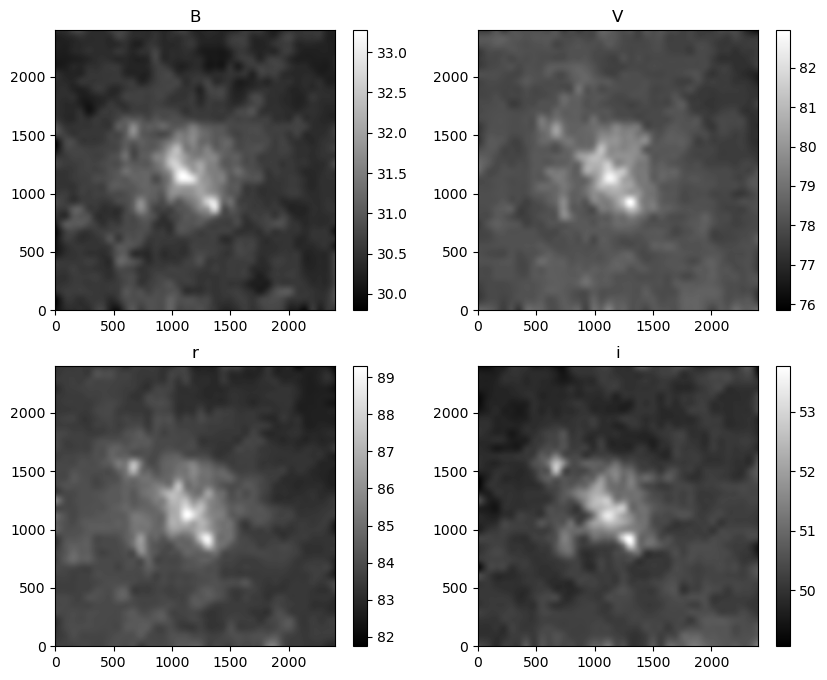

In [21]:
#visual inspection of background (Notice the background average & std are very different)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
im1 = axs[0, 0].imshow(B_bkg.back(), interpolation='nearest', cmap='gray', origin='lower')
fig.colorbar(im1, ax=axs[0, 0])
axs[0, 0].set_title("B")

im2 = axs[0, 1].imshow(V_bkg.back(), interpolation='nearest', cmap='gray', origin='lower')
fig.colorbar(im2, ax=axs[0, 1])
axs[0, 1].set_title("V")

im3 = axs[1, 0].imshow(r_bkg.back(), interpolation='nearest', cmap='gray', origin='lower')
fig.colorbar(im3, ax=axs[1, 0])
axs[1, 0].set_title("r")

im4 = axs[1, 1].imshow(i_bkg.back(), interpolation='nearest', cmap='gray', origin='lower')
fig.colorbar(im4, ax=axs[1, 1])
axs[1, 1].set_title("i")

fig.savefig('background.png', dpi = 300)

In [14]:
# Detect star in B filter
B_objects = sep.extract(B_sub, thresh = 1.5, err=B_bkg.globalrms)

#Threshold pixel value for detection. If an err or var array is not given, this is interpreted as an absolute threshold. 
#If err or var is given, this is interpreted as a relative threshold
print(f"Detected {len(B_objects)} sources")
#get rid of bad pixel (some single pixel)
B_objects_filter = B_objects[B_objects['tnpix'] > 10]     #tnpix: number of pixel above threshold
print(f"Detected {len(B_objects_filter)} sources")
#save x y position of the star centroid
B_x, B_y = B_objects_filter['x'], B_objects_filter['y']
B_radius = np.rint(np.sqrt(B_objects_filter['npix']/np.pi)) #npix: number of pixel belong to the object

Detected 1122 sources
Detected 911 sources


In [15]:
# Detect star in V filter
V_objects = sep.extract(V_sub, thresh = 1.5, err=V_bkg.globalrms)

#Threshold pixel value for detection. If an err or var array is not given, this is interpreted as an absolute threshold. 
#If err or var is given, this is interpreted as a relative threshold
print(f"Detected {len(V_objects)} sources")
#get rid of bad pixel (some single pixel)
V_objects_filter = V_objects[V_objects['tnpix'] > 10]     #tnpix: number of pixel above threshold
print(f"Detected {len(V_objects_filter)} sources")
#save x y position of the star centroid
V_x, V_y = V_objects_filter['x'], V_objects_filter['y']
V_radius = np.rint(np.sqrt(V_objects_filter['npix']/np.pi)) #npix: number of pixel belong to the object

Detected 1288 sources
Detected 1097 sources


In [16]:
# Detect star in r filter
r_objects = sep.extract(r_sub, thresh = 1.5, err=r_bkg.globalrms)

#Threshold pixel value for detection. If an err or var array is not given, this is interpreted as an absolute threshold. 
#If err or var is given, this is interpreted as a relative threshold
print(f"Detected {len(r_objects)} sources")
#get rid of bad pixel (some single pixel)
r_objects_filter = r_objects[r_objects['tnpix'] > 10]     #tnpix: number of pixel above threshold
print(f"Detected {len(r_objects_filter)} sources")
#save x y position of the star centroid
r_x, r_y = r_objects_filter['x'], r_objects_filter['y']
r_radius = np.rint(np.sqrt(r_objects_filter['npix']/np.pi)) #npix: number of pixel belong to the object

Detected 1484 sources
Detected 1231 sources


In [17]:
# Detect star in i filter
i_objects = sep.extract(i_sub, thresh = 1.5, err=i_bkg.globalrms)

#Threshold pixel value for detection. If an err or var array is not given, this is interpreted as an absolute threshold. 
#If err or var is given, this is interpreted as a relative threshold
print(f"Detected {len(i_objects)} sources")
#get rid of bad pixel (some single pixel)
i_objects_filter = i_objects[i_objects['tnpix'] > 10]     #tnpix: number of pixel above threshold
print(f"Detected {len(i_objects_filter)} sources")
#save x y position of the star centroid
i_x, i_y = i_objects_filter['x'], i_objects_filter['y']
i_radius = np.rint(np.sqrt(i_objects_filter['npix']/np.pi)) #npix: number of pixel belong to the object

Detected 1446 sources
Detected 1184 sources


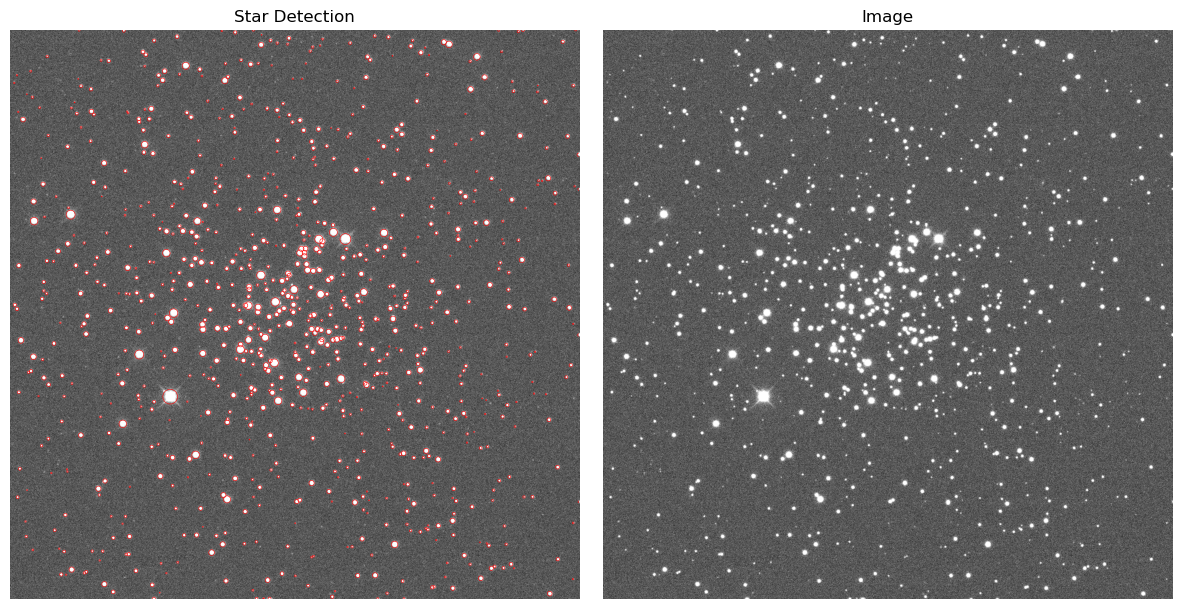

In [22]:
# visual inspect B
visual_detect(B_sci, B_x, B_y, size=B_radius, save='star_in_B')

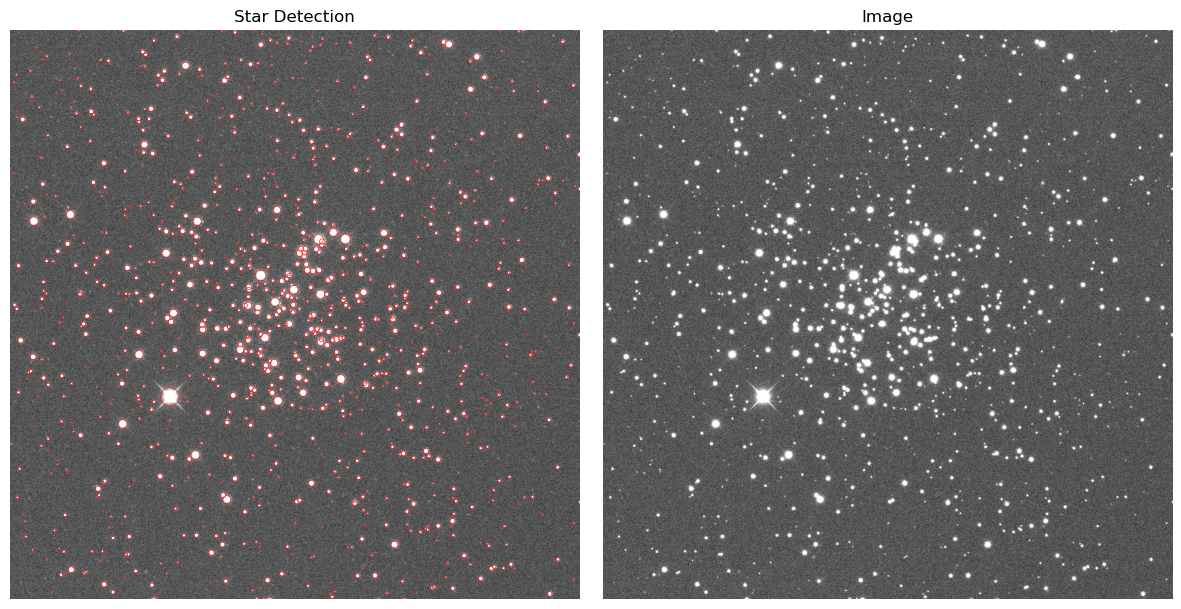

In [15]:
# visual inspect V
visual_detect(V_sci, V_x, V_y, size=V_radius)

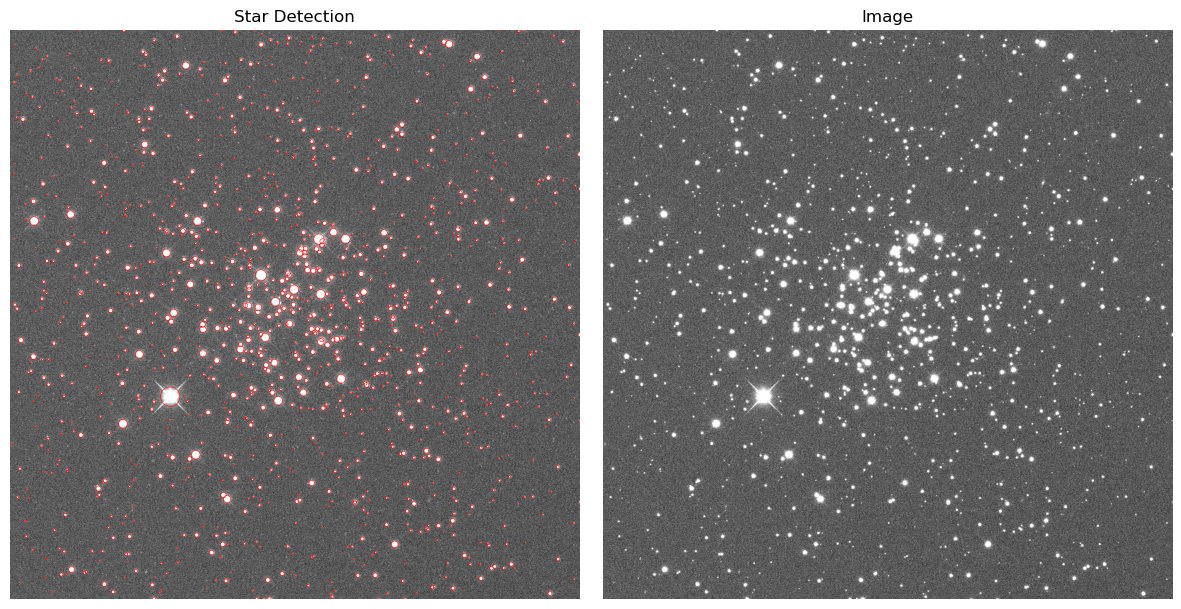

In [16]:
# visual inspect r
visual_detect(r_sci, r_x, r_y, size=r_radius)

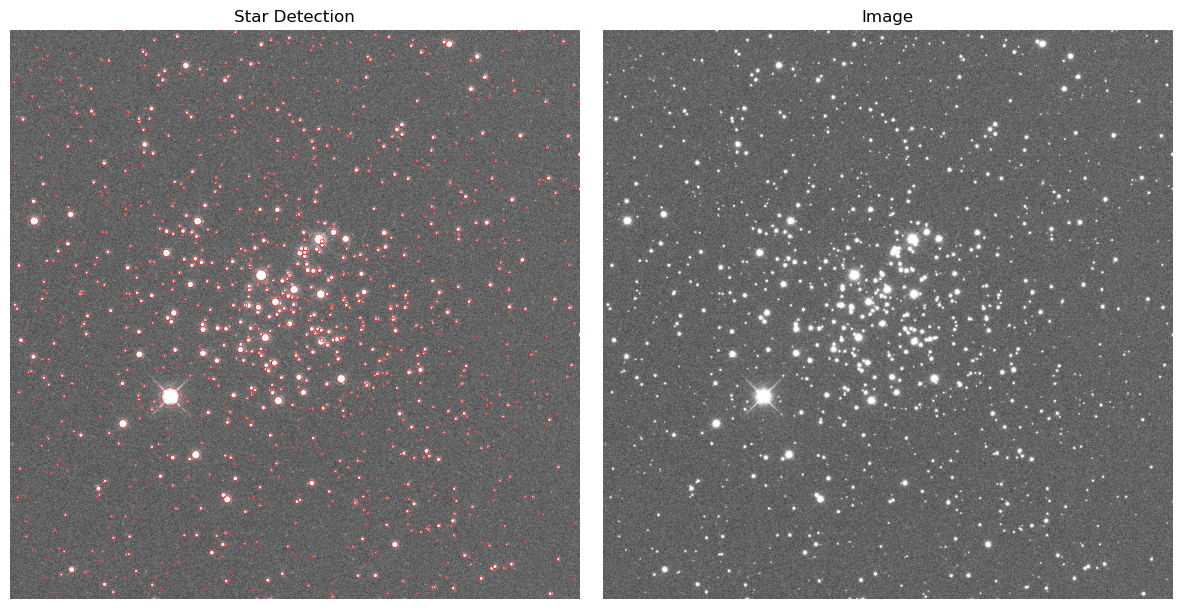

In [17]:
# visual inspect i
visual_detect(i_sci, i_x, i_y, size=i_radius)

## Matching Gaia Catelog
Since the number of stars detected in each filter is different, I would match each of them to the gaia catelog, then only consider the stars that are detected in all 4 channel and found in gaia catelog. 

In [26]:
wcs = WCS(B_header) #header is stored when we import the data, go to that block and check if the variable name matches
ra, dec = wcs.all_pix2world(B_x, B_y, 0) #x & y are the position of stars we have selected, convert their xy position to ra and dec

# Convert to a list of tuple, each tuple is the ra and dec of a star
B_image_coords = SkyCoord(ra = ra * u.deg, dec = dec * u.deg)

# Match to gaia catelog
### Get the region in the gaia
query = f"""
    SELECT * 
    FROM gaiadr3.gaia_source
    WHERE ra BETWEEN {ra.min()} AND {ra.max()}
    AND dec BETWEEN {dec.min()} AND {dec.max()}
"""
job = Gaia.launch_job_async(query)

### get the result from database
B_gaia_results = job.get_results() #this takes like 6 seconds, so I seperate the it from the rest of the code

Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Query finished. [astroquery.utils.tap.core]


In [43]:
B_gaia_results.info()

<Table length=2488>
              name               dtype       unit                                                                  description                                                              n_bad
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- -----
                    solution_id   int64                                                                                                                                 Solution Identifier     0
                    DESIGNATION  object                                                                                         Unique source designation (unique across all Data Releases)     0
                      SOURCE_ID   int64                                                                                  Unique source identifier (unique within a particular Data Release)     0
          

In [27]:
wcs = WCS(V_header) #header is stored when we import the data, go to that block and check if the variable name matches
ra, dec = wcs.all_pix2world(V_x, V_y, 0) #x & y are the position of stars we have selected, convert their xy position to ra and dec

# Convert to a list of tuple, each tuple is the ra and dec of a star
V_image_coords = SkyCoord(ra = ra * u.deg, dec = dec * u.deg)

# Match to gaia catelog
### Get the region in the gaia
query = f"""
    SELECT * 
    FROM gaiadr3.gaia_source
    WHERE ra BETWEEN {ra.min()} AND {ra.max()}
    AND dec BETWEEN {dec.min()} AND {dec.max()}
"""
#job = Gaia.launch_job_async(query)

### get the result from database
#V_gaia_results = job.get_results() #this takes like 6 seconds, so I seperate the it from the rest of the code

In [28]:
wcs = WCS(r_header) #header is stored when we import the data, go to that block and check if the variable name matches
ra, dec = wcs.all_pix2world(r_x, r_y, 0) #x & y are the position of stars we have selected, convert their xy position to ra and dec

# Convert to a list of tuple, each tuple is the ra and dec of a star
r_image_coords = SkyCoord(ra = ra * u.deg, dec = dec * u.deg)

# Match to gaia catelog
### Get the region in the gaia
query = f"""
    SELECT * 
    FROM gaiadr3.gaia_source
    WHERE ra BETWEEN {ra.min()} AND {ra.max()}
    AND dec BETWEEN {dec.min()} AND {dec.max()}
"""
#job = Gaia.launch_job_async(query)

### get the result from database
#r_gaia_results = job.get_results() #this takes like 6 seconds, so I seperate the it from the rest of the code

In [29]:
wcs = WCS(i_header) #header is stored when we import the data, go to that block and check if the variable name matches
ra, dec = wcs.all_pix2world(i_x, i_y, 0) #x & y are the position of stars we have selected, convert their xy position to ra and dec

# Convert to a list of tuple, each tuple is the ra and dec of a star
i_image_coords = SkyCoord(ra = ra * u.deg, dec = dec * u.deg)

# Match to gaia catelog
### Get the region in the gaia
query = f"""
    SELECT * 
    FROM gaiadr3.gaia_source
    WHERE ra BETWEEN {ra.min()} AND {ra.max()}
    AND dec BETWEEN {dec.min()} AND {dec.max()}
"""
#job = Gaia.launch_job_async(query)

### get the result from database
#i_gaia_results = job.get_results() #this takes like 6 seconds, so I seperate the it from the rest of the code

In [ ]:
# check the number of stars returned (value are close but not the same, indicate the image is well aligned, its hard to get all value the same though)
print("B Querry has {} objects".format(len(B_gaia_results)))
#print("B Querry has {} objects".format(len(V_gaia_results)))
#print("B Querry has {} objects".format(len(r_gaia_results)))
#print("B Querry has {} objects".format(len(i_gaia_results)))

B Querry has 2488 objects


From here, I could potentially find the matched star in each filter and then find stars that exists in all tables (4 in total), but the last step is hard to implement and computational heavy. Instead, since the 4 filter are well-aligned, I am going to match all filter with respect to the gaia catelog for filter B. 

In [31]:
# Cross-match using astropy.coordinates
### idx = index in gaia_coords for each match
### d2d = sep2d, the on-sky seperation between each match, use to check if the match looks good
B_gaia_coords = SkyCoord(ra=B_gaia_results['ra'], dec=B_gaia_results['dec']) #gaia result is already in degree

B_idx, B_d2d, _ = B_image_coords.match_to_catalog_sky(B_gaia_coords)  #coordinates.match_to_catalog_sky(catalog coordinates)

V_idx, V_d2d, _ = V_image_coords.match_to_catalog_sky(B_gaia_coords)

r_idx, r_d2d, _ = r_image_coords.match_to_catalog_sky(B_gaia_coords)

i_idx, i_d2d, _ = i_image_coords.match_to_catalog_sky(B_gaia_coords)

In [32]:
# Select stars match within 3 arc seconds
B_matched_star = B_d2d < 3 * u.arcsec
print(f"B filter: Matche within 3 arc sec: {B_matched_star.sum()} out of {B_image_coords.size}" )

V_matched_star = V_d2d < 3 * u.arcsec
print(f"V filter: Matche within 3 arc sec: {V_matched_star.sum()} out of {V_image_coords.size}" )

r_matched_star = r_d2d < 3 * u.arcsec
print(f"rp filter: Matche within 3 arc sec: {r_matched_star.sum()} out of {r_image_coords.size}" )

i_matched_star = i_d2d < 3 * u.arcsec
print(f"ip filter: Matche within 3 arc sec: {i_matched_star.sum()} out of {i_image_coords.size}" )

B filter: Matche within 3 arc sec: 902 out of 911
V filter: Matche within 3 arc sec: 1086 out of 1097
rp filter: Matche within 3 arc sec: 1214 out of 1231
ip filter: Matche within 3 arc sec: 1170 out of 1184


In [33]:
# index in gaia table of matched stars, x y, and radius of matched stars
B_matched_idx = B_idx[B_matched_star]
B_matched_x = B_x[B_matched_star]
B_matched_y = B_y[B_matched_star]
B_matched_radius = B_radius[B_matched_star]

V_matched_idx = V_idx[V_matched_star]
V_matched_x = V_x[V_matched_star]
V_matched_y = V_y[V_matched_star]
V_matched_radius = V_radius[V_matched_star]

r_matched_idx = r_idx[r_matched_star]
r_matched_x = r_x[r_matched_star]
r_matched_y = r_y[r_matched_star]
r_matched_radius = r_radius[r_matched_star]

i_matched_idx = i_idx[i_matched_star]
i_matched_x = i_x[i_matched_star]
i_matched_y = i_y[i_matched_star]
i_matched_radius = i_radius[i_matched_star]

# select the column we need
gaia_info = B_gaia_results['DESIGNATION', 'SOURCE_ID', 'pm','parallax']

# add column for the filtering step
gaia_info['detect_count'] = 0

gaia_info['Bx'] = 0 # x in B filter
gaia_info['By'] = 0 # y in B filter
gaia_info['Br'] = 0 # r in B filter

gaia_info['Vx'] = 0
gaia_info['Vy'] = 0
gaia_info['Vr'] = 0

gaia_info['rx'] = 0
gaia_info['ry'] = 0
gaia_info['rr'] = 0

gaia_info['ix'] = 0
gaia_info['iy'] = 0
gaia_info['ir'] = 0

for i in range(len(B_matched_idx)):
    ind = B_matched_idx[i]
    gaia_info['detect_count'][ind] += 1
    gaia_info['Bx'][ind] = B_matched_x[i]
    gaia_info['By'][ind] = B_matched_y[i]
    gaia_info['Br'][ind] = B_matched_radius[i]

for i in range(len(V_matched_idx)):
    ind = V_matched_idx[i]
    gaia_info['detect_count'][ind] += 1
    gaia_info['Vx'][ind] = V_matched_x[i]
    gaia_info['Vy'][ind] = V_matched_y[i]
    gaia_info['Vr'][ind] = V_matched_radius[i]

for i in range(len(r_matched_idx)):
    ind = r_matched_idx[i]
    gaia_info['detect_count'][ind] += 1
    gaia_info['rx'][ind] = r_matched_x[i]
    gaia_info['ry'][ind] = r_matched_y[i]
    gaia_info['rr'][ind] = r_matched_radius[i]
for i in range(len(i_matched_idx)):
    ind = i_matched_idx[i]
    gaia_info['detect_count'][ind] += 1
    gaia_info['ix'][ind] = i_matched_x[i]
    gaia_info['iy'][ind] = i_matched_y[i]
    gaia_info['ir'][ind] = i_matched_radius[i]

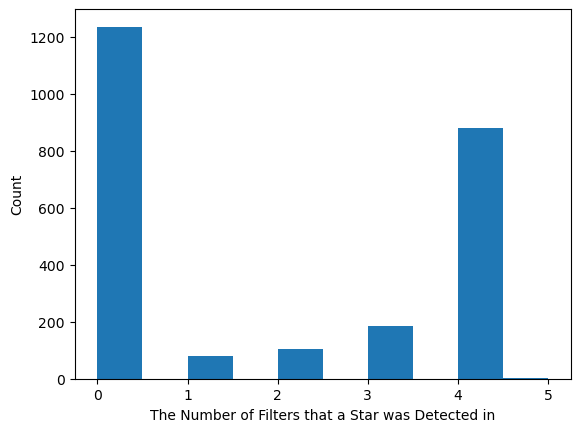

In [36]:
plt.hist(gaia_info['detect_count'])
plt.xlabel("The Number of Filters that a Star was Detected in")
plt.ylabel("Count")
plt.savefig("star_count_by_filter.png", dpi = 300)

In [37]:
gaia_select = gaia_info[gaia_info['detect_count'] == 4]
len(gaia_select)

881

## Define the cluster
base on parallex data and proper motion data

$${Distance (parsecs)} \approx \frac{1000}{Parallax (mas)}$$

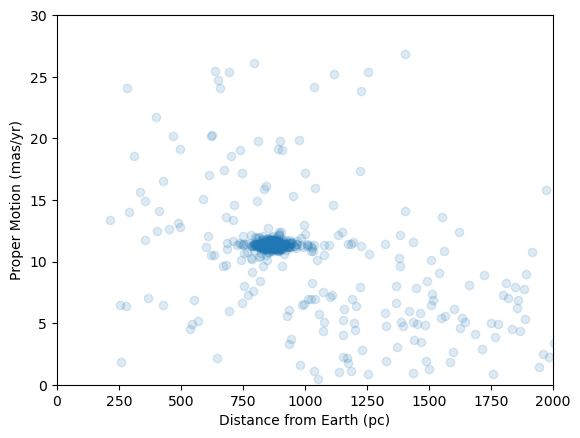

In [45]:
plt.scatter(1000/np.array(gaia_select['parallax']), gaia_select['pm'], alpha=0.15)
plt.xlim(0, 2000)
plt.ylim(0, 30)
plt.xlabel("Distance from Earth (pc)")
plt.ylabel("Proper Motion (mas/yr)")
plt.savefig("pm_distance.png", dpi = 300)

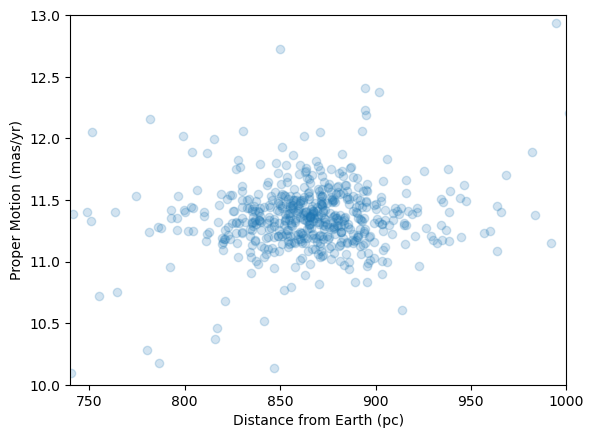

In [46]:
plt.scatter(1000/np.array(gaia_select['parallax']), gaia_select['pm'], alpha=0.2)
plt.xlim(740, 1000)
plt.ylim(10, 13)
plt.xlabel("Distance from Earth (pc)")
plt.ylabel("Proper Motion (mas/yr)")
plt.savefig("pm_distance_zoom.png", dpi = 300)

In [109]:
gaia_cluster = gaia_select[:][740 < 1000/np.array(gaia_select['parallax'])]
gaia_cluster = gaia_cluster[:][1000/np.array(gaia_cluster['parallax']) < 1000]
gaia_cluster = gaia_cluster[:][gaia_cluster['pm'] > 10]
gaia_cluster = gaia_cluster[:][gaia_cluster['pm'] < 13]
len(gaia_cluster) # NASA says M67 has over 500 stars, so this result is satisfactory. 

553

In [110]:
1000*np.std(gaia_cluster['parallax'])/(np.mean(gaia_cluster['parallax']))**2

36.24651979819985

This is amazing, I was expecting that the number might be different, but 553 is exactly the number of star we get at this step when processing B filter alone. This suggest that the added filter-matching step did not interfere with the result.

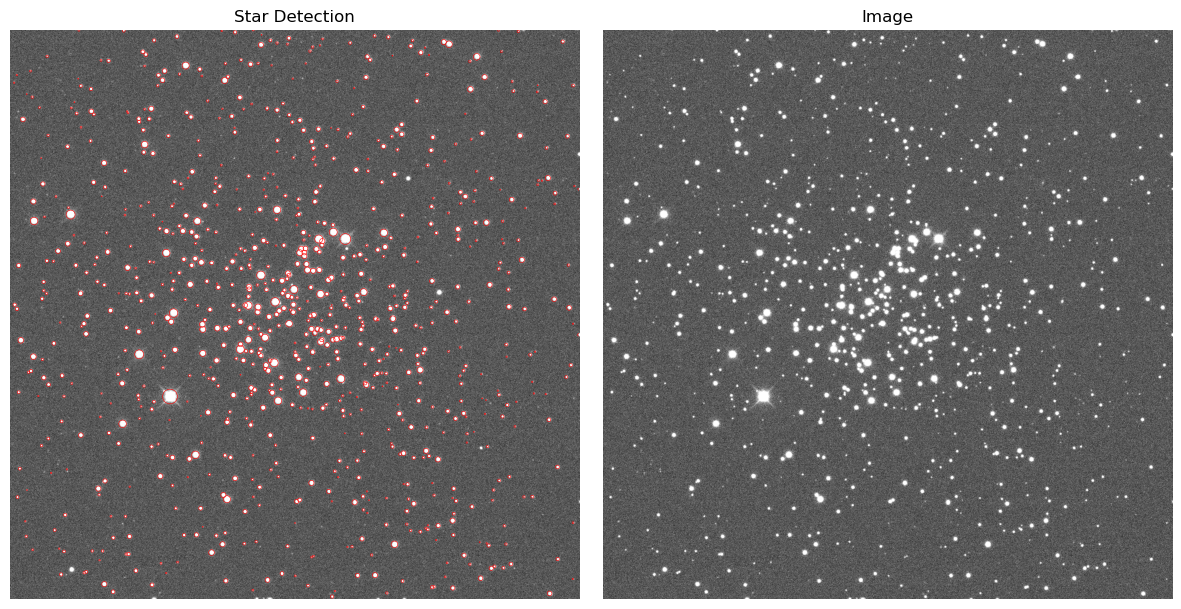

In [111]:
# before apply the parallex and pm condition
visual_detect(B_sci, gaia_select['Bx'], gaia_select['By'], size = gaia_select['Br'])

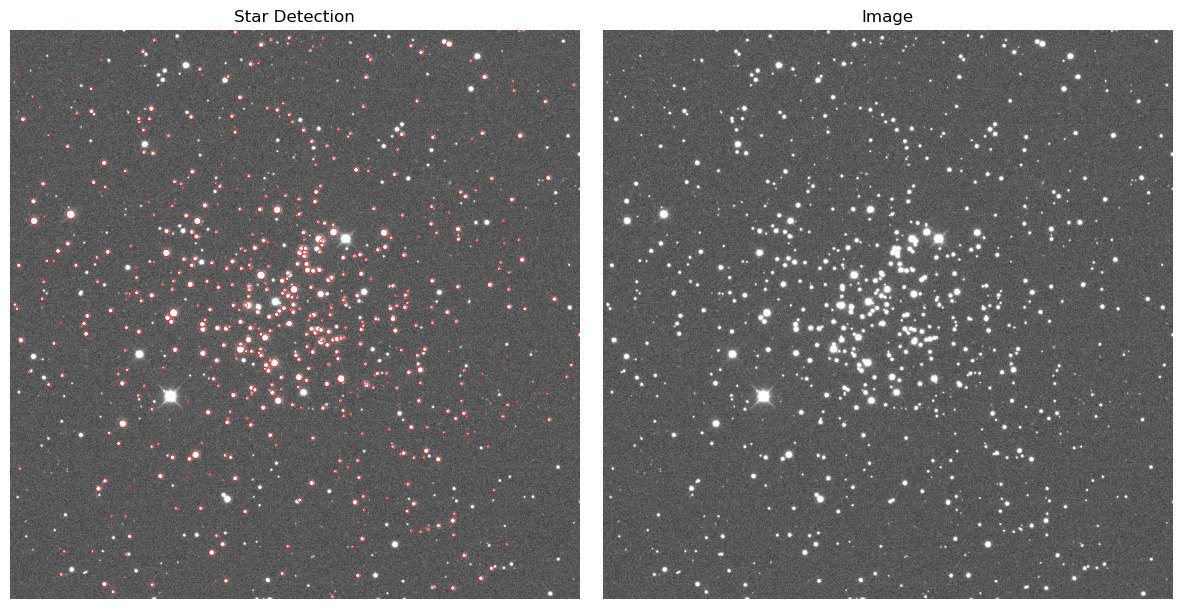

In [112]:
# After apply the parallex and pm condition
visual_detect(B_sci, gaia_cluster['Bx'], gaia_cluster['By'], size = gaia_cluster['Br'], save='star_in_B_select')

Notice that a few bright star are in fact not in the cluster since they have distinct parallel or pm characteristics.

## Draw Annulus
Detect local background around a star. For now, for each star center, select one inner surface and one outer surface

In [113]:
# mask
def mask(outer, inner): # radius of inner and outer annulus
    outer = int(outer)
    inner = int(inner)
    frame = np.zeros([2*outer+1, 2*outer+1])
    center = outer
    
    for x in range(2*outer+1):
        for y in range(2*outer+1):
            if (x-outer)**2 + (y-outer)**2 <= (outer+0.5)**2 and (x-outer)**2 + (y-outer)**2 >= (inner+0.5)**2:
                frame[x][y] = 1
    return frame, np.sum(frame), center


In [114]:
# visualize annulus
def visual_annulus(sci_image, x, y, size = 10, x_win = (0,0), y_win = (0,0,), stretch = True, heatmap = False, save=''):
    if x_win == (0,0):
        x_win = (0, len(sci_image[0]))
    if y_win == (0,0):
        y_win = (0, len(sci_image))
    if stretch:
        linear_stretched_image = linear_stretch(sci_image[y_win[0]:y_win[1]+1, x_win[0]:x_win[1]+1])
    else:
        linear_stretched_image = np.copy(sci_image[y_win[0]:y_win[1]+1, x_win[0]:x_win[1]+1])

    # Set up the plot to display images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original SCI image with a circle around the selected star
    if heatmap:
        c0 = axes[0].imshow(linear_stretched_image, cmap='RdBu')
        fig.colorbar(c0, ax=axes[0])
    else:
        axes[0].imshow(linear_stretched_image, cmap='gray')
    axes[0].set_title('Star Detection')
    axes[0].axis('off')

    # Draw a circle around the selected star
    # check if size is a int or a list
    if isinstance(size, int):
        # draw matched stars
        for i in range(len(x)):
            circle = plt.Circle((x[i]-x_win[0], y[i]-y_win[0]), size*2, color='red', fill=False, linewidth=0.4, alpha = 0.8)
            axes[0].add_patch(circle)
            circle = plt.Circle((x[i]-x_win[0], y[i]-y_win[0]), size*2+10, color='red', fill=False, linewidth=0.4, alpha = 0.8)
            axes[0].add_patch(circle)
    else:
        # draw matched stars
        for i in range(len(x)):
            circle = plt.Circle((x[i]-x_win[0], y[i]-y_win[0]), size[i]*2, color='red', fill=False, linewidth=0.4, alpha = 0.8)
            axes[0].add_patch(circle)
            circle = plt.Circle((x[i]-x_win[0], y[i]-y_win[0]), size[i]*2+10, color='red', fill=False, linewidth=0.4, alpha = 0.8)
            axes[0].add_patch(circle)

    # Display the linearly stretched image
    if heatmap:
        c1 = axes[1].imshow(linear_stretched_image, cmap='RdBu')
        fig.colorbar(c1, ax=axes[1])
    else:
        axes[1].imshow(linear_stretched_image, cmap='gray')
    axes[1].set_title('Image')
    axes[1].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()
    if save != '':
        fig.savefig(str(save)+'.png', dpi = 300)

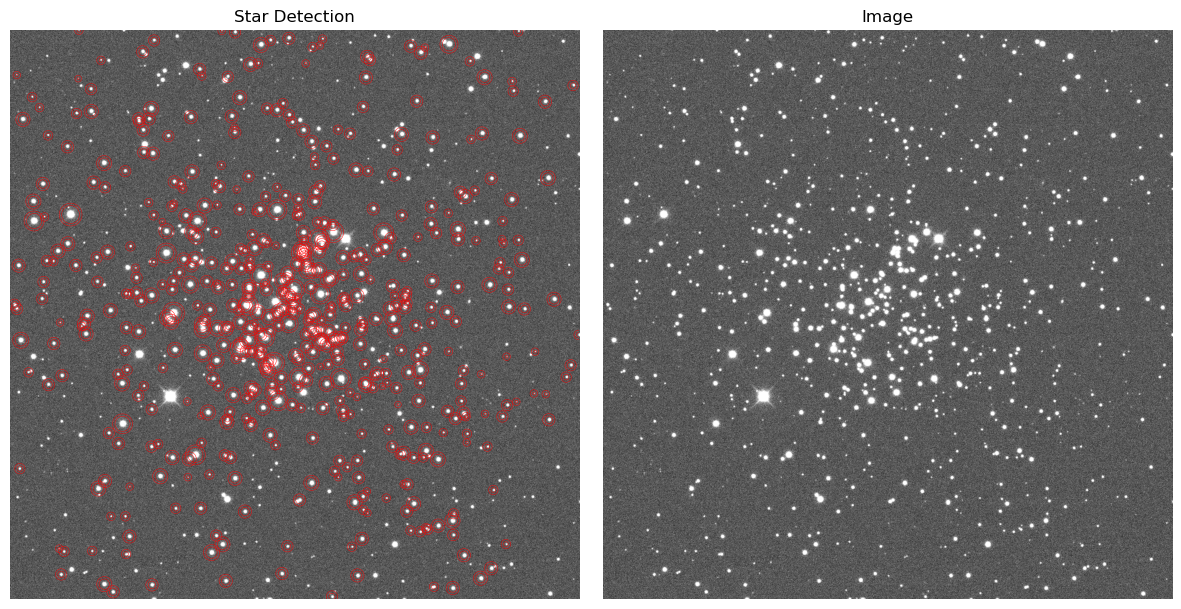

In [115]:
visual_annulus(B_sci, gaia_cluster['Bx'], gaia_cluster['By'], size = gaia_cluster['Br'], save='annulus_in_B')

Extract the intensity from the bkg of each filter

In [116]:
gaia_cluster['B_bkg_intensity'] = 0
gaia_cluster['V_bkg_intensity'] = 0
gaia_cluster['r_bkg_intensity'] = 0
gaia_cluster['i_bkg_intensity'] = 0

In [117]:
image_xlim = len(B_sci[0]) #2400
image_ylim = len(B_sci)

B_bkg_image = B_bkg.back()
V_bkg_image = V_bkg.back()
r_bkg_image = r_bkg.back()
i_bkg_image = i_bkg.back()

# B
for ind in range(len(gaia_cluster)):
    x, y, r = gaia_cluster['Bx', 'By', 'Br'][ind]
    annulus, pix_count, center = mask(r*2+10, r*2) #adjust the spacing between inner & outer annulus here
    intensity = 0
    pix = 0
    for i in range(len(annulus)): #y
        for j in range(len(annulus[0])): #x
            if annulus[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += B_bkg_image[y_pos][x_pos]                     # alternatively, I could check if the pixel in sci_image is within 3 sigma
                    pix += 1
    gaia_cluster['B_bkg_intensity'][ind] = intensity/pix

# V
for ind in range(len(gaia_cluster)):
    x, y, r = gaia_cluster['Vx', 'Vy', 'Vr'][ind]
    annulus, pix_count, center = mask(r*2+10, r*2) #adjust the spacing between inner & outer annulus here
    intensity = 0
    pix = 0
    for i in range(len(annulus)): #y
        for j in range(len(annulus[0])): #x
            if annulus[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += V_bkg_image[y_pos][x_pos]                     # alternatively, I could check if the pixel in sci_image is within 3 sigma
                    pix += 1
    gaia_cluster['V_bkg_intensity'][ind] = intensity/pix

# r
for ind in range(len(gaia_cluster)):
    x, y, r = gaia_cluster['rx', 'ry', 'rr'][ind]
    annulus, pix_count, center = mask(r*2+10, r*2) #adjust the spacing between inner & outer annulus here
    intensity = 0
    pix = 0
    for i in range(len(annulus)): #y
        for j in range(len(annulus[0])): #x
            if annulus[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += r_bkg_image[y_pos][x_pos]                     # alternatively, I could check if the pixel in sci_image is within 3 sigma
                    pix += 1
    gaia_cluster['r_bkg_intensity'][ind] = intensity/pix

# i
for ind in range(len(gaia_cluster)):
    x, y, r = gaia_cluster['ix', 'iy', 'ir'][ind]
    annulus, pix_count, center = mask(r*2+10, r*2) #adjust the spacing between inner & outer annulus here
    intensity = 0
    pix = 0
    for i in range(len(annulus)): #y
        for j in range(len(annulus[0])): #x
            if annulus[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += i_bkg_image[y_pos][x_pos]                     # alternatively, I could check if the pixel in sci_image is within 3 sigma
                    pix += 1
    gaia_cluster['i_bkg_intensity'][ind] = intensity/pix



In [118]:
gaia_cluster[:10]

<Table length=10>
        DESIGNATION             SOURCE_ID      ... i_bkg_intensity
                                               ...                
           object                 int64        ...      int64     
--------------------------- ------------------ ... ---------------
Gaia DR3 604962640612163200 604962640612163200 ...              50
Gaia DR3 598906771084100224 598906771084100224 ...              50
Gaia DR3 604963602684833920 604963602684833920 ...              50
Gaia DR3 604963637044570880 604963637044570880 ...              50
Gaia DR3 604962365734255744 604962365734255744 ...              50
Gaia DR3 604964255519855232 604964255519855232 ...              50
Gaia DR3 604912196220603264 604912196220603264 ...              50
Gaia DR3 604964010706281856 604964010706281856 ...              49
Gaia DR3 598903953585548672 598903953585548672 ...              50
Gaia DR3 604962743691561472 604962743691561472 ...              50

## Calculate intensity in Aperture
calculate the intensity in the aperture

In [119]:
# slightly modify the mask
def aperture_mask(outer): # radius of inner and outer annulus
    outer = int(outer)
    frame = np.zeros([2*outer+1, 2*outer+1])
    center = outer
    
    for x in range(2*outer+1):
        for y in range(2*outer+1):
            if (x-outer)**2 + (y-outer)**2 <= (outer+0.5)**2:
                frame[x][y] = 1
    return frame, np.sum(frame), center

In [120]:
gaia_cluster['B_intensity'] = 0
gaia_cluster['V_intensity'] = 0
gaia_cluster['r_intensity'] = 0
gaia_cluster['i_intensity'] = 0

In [121]:
image_xlim = len(B_sci[0]) #2400
image_ylim = len(B_sci)

# B
for ind in range(len(gaia_cluster)):
    x, y, r, bkg_intensity = gaia_cluster['Bx', 'By', 'Br', 'B_bkg_intensity'][ind]
    aperture, pix_count, center = aperture_mask(r)
    intensity = 0
    for i in range(len(aperture)): #y
        for j in range(len(aperture[0])): #x
            if aperture[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += B_sci[y_pos][x_pos]-bkg_intensity
    gaia_cluster['B_intensity'][ind] = intensity

# V
for ind in range(len(gaia_cluster)):
    x, y, r, bkg_intensity = gaia_cluster['Vx', 'Vy', 'Vr', 'V_bkg_intensity'][ind]
    aperture, pix_count, center = aperture_mask(r)
    intensity = 0
    for i in range(len(aperture)): #y
        for j in range(len(aperture[0])): #x
            if aperture[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += V_sci[y_pos][x_pos]-bkg_intensity
    gaia_cluster['V_intensity'][ind] = intensity

# r
for ind in range(len(gaia_cluster)):
    x, y, r, bkg_intensity = gaia_cluster['rx', 'ry', 'rr', 'r_bkg_intensity'][ind]
    aperture, pix_count, center = aperture_mask(r)
    intensity = 0
    for i in range(len(aperture)): #y
        for j in range(len(aperture[0])): #x
            if aperture[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += r_sci[y_pos][x_pos]-bkg_intensity
    gaia_cluster['r_intensity'][ind] = intensity

# i
for ind in range(len(gaia_cluster)):
    x, y, r, bkg_intensity = gaia_cluster['ix', 'iy', 'ir', 'i_bkg_intensity'][ind]
    aperture, pix_count, center = aperture_mask(r)
    intensity = 0
    for i in range(len(aperture)): #y
        for j in range(len(aperture[0])): #x
            if aperture[i][j] == 1:
                x_pos = int(x - r + j)
                y_pos = int(y - r + i)
                if  0 <= x_pos < image_xlim and 0 <= y_pos < image_ylim:
                    intensity += i_sci[y_pos][x_pos]-bkg_intensity
    gaia_cluster['i_intensity'][ind] = intensity

In [122]:
gaia_cluster[:5]

<Table length=5>
        DESIGNATION             SOURCE_ID      ... r_intensity i_intensity
                                               ...                        
           object                 int64        ...    int64       int64   
--------------------------- ------------------ ... ----------- -----------
Gaia DR3 604962640612163200 604962640612163200 ...       12667        4320
Gaia DR3 598906771084100224 598906771084100224 ...       17914        8504
Gaia DR3 604963602684833920 604963602684833920 ...       26193       12652
Gaia DR3 604963637044570880 604963637044570880 ...       14211        6540
Gaia DR3 604962365734255744 604962365734255744 ...       85570       37636

## Intensity to Flux, then to Magnitude

We assume the relationship between the *intensity* of a star we measure in A/D units as $f(\lambda)$ and the actual *flux* of the star $F(\lambda)$ in $\frac{photon}{{cm}^2s\mu}$ is linear
$$
f(\lambda) = C(\lambda) F(\lambda) 
$$
where C is a constant depends on the telescope, CCD, and *wavelength*. However, since the wavelength for each photo in a specific filter is the same, we only need to calibrate this once for every filter. 

The difference in magnitude in two stars is then given by 
$$
m_1 - m_2 = - 2.5 \log_{10}(\frac{F_1(\lambda)}{F_2(\lambda)})
$$
$$
m_1 - m_2 = - 2.5 \log_{10}(\frac{f_1(\lambda)/C(\lambda)}{f_2(\lambda)/C(\lambda)}) = - 2.5 \log_{10}(\frac{f_1(\lambda)}{f_2(\lambda)})
$$
Hence, if we are considering relative magnitude between two stars, then we may use intensity as flux.
$$
m_1 =  m_0 - 2.5 \log_{10}(\frac{f_1(\lambda)}{f_0(\lambda)})
$$

To get information on the magnitude in different filter for reference star, go to the SIMBAD database
- NGC 2682 (M67): https://simbad.u-strasbg.fr/simbad/sim-id?Ident=%401136125&Name=NGC++2682&submit=display+all+measurements#lab_meas
- Query object nearby: https://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.0%2B11+48+50&CooFrame=ICRS&CooEqui=2000.0&CooEpoch=J2000&Radius.unit=arcmin&submit=Query+around&Radius=2
- Object type: https://simbad.cds.unistra.fr/guide/otypes.htx
- SDSS: https://skyserver.sdss.org/dr18/VisualTools/explore/summary

I found dozens of reference star candidate
1. chatgpt says A F G K stars are good and M O stars are bad. I only have F and G, I am going with F stars
2. I have the manitude default in Johnson Bassel filter, which is what we use for B, V. But I don't know how to find/switch to SDSS filter for r' and i'

- Cl* NGC 2682 ES IV-1
- NGC 2682 155 (almost touch another star, may be a bad reference)
- NGC 2682 149b
- NGC 2682 126
- Cl* NGC 2682 ES IV-17
- NGC 2682 164 (red giant)
- Proceed with one of above, then go back later to find the best option

### Single Reference Star
Proceed with Cl* NGC 2682 ES IV-17 (Gaia DR3 604921134048349824)
- B   14.97	(SIMBAD)
- V   14.366 (SIMBAD)
- r'	14.141 (SDSS)
- i'	13.982 (SDSS)

In [123]:
# find the intensity of the reference star
ref_star = gaia_cluster[gaia_cluster['DESIGNATION'] == 'Gaia DR3 604921134048349824']

#extract intensity of ref star
B_f_0 = ref_star['B_intensity'][0]
V_f_0 = ref_star['V_intensity'][0]
r_f_0 = ref_star['r_intensity'][0]
i_f_0 = ref_star['i_intensity'][0]

# set magnitude of the reference star
B_m_0 = 14.97
V_m_0 = 14.366
r_m_0 = 14.141
i_m_0 = 13.982

In [124]:
ref_star

<Table length=1>
        DESIGNATION             SOURCE_ID      ... r_intensity i_intensity
                                               ...                        
           object                 int64        ...    int64       int64   
--------------------------- ------------------ ... ----------- -----------
Gaia DR3 604921134048349824 604921134048349824 ...       34680       15186

In [125]:
B_magnitude = np.zeros(len(gaia_cluster))
for i in range(len(gaia_cluster)):
    B_magnitude[i] = B_m_0 - 2.5 * np.log10(gaia_cluster['B_intensity'][i] / B_f_0)

V_magnitude = np.zeros(len(gaia_cluster))
for i in range(len(gaia_cluster)):
    V_magnitude[i] = V_m_0 - 2.5 * np.log10(gaia_cluster['V_intensity'][i] / V_f_0)

r_magnitude = np.zeros(len(gaia_cluster))
for i in range(len(gaia_cluster)):
    r_magnitude[i] = r_m_0 - 2.5 * np.log10(gaia_cluster['r_intensity'][i] / r_f_0)

i_magnitude = np.zeros(len(gaia_cluster))
for i in range(len(gaia_cluster)):
    i_magnitude[i] = i_m_0 - 2.5 * np.log10(gaia_cluster['i_intensity'][i] / i_f_0)

gaia_cluster['B_magnitude'] = B_magnitude
gaia_cluster['V_magnitude'] = V_magnitude
gaia_cluster['r_magnitude'] = r_magnitude
gaia_cluster['i_magnitude'] = i_magnitude

In [126]:
gaia_cluster[0:5]

<Table length=5>
        DESIGNATION             SOURCE_ID      ...    i_magnitude    
                                               ...                   
           object                 int64        ...      float64      
--------------------------- ------------------ ... ------------------
Gaia DR3 604962640612163200 604962640612163200 ... 15.346899121817463
Gaia DR3 598906771084100224 598906771084100224 ... 14.611550360066643
Gaia DR3 604963602684833920 604963602684833920 ... 14.180210530745532
Gaia DR3 604963637044570880 604963637044570880 ... 14.896664118044075
Gaia DR3 604962365734255744 604962365734255744 ... 12.996599839203613

## Calculate Luminosity

The formula for luminosity is 

$$
L = L_\odot {10}^{\frac{M_\odot - M_V}{2.5}}
$$

where M is the absolute magnitude in visible band

The Absolute Magnitude of Sun is $M_\odot = 4.83$

The absolute magnitude is then calculate through
$$
M_V = m_V - 5\log_{10}(d/d_0) = m_V - 5\log_{10}(d) + 5
$$

- $m_V$ is the apparent magnitude in the V band.
- d is the distance to the star in parsecs.
- $d_0 = 10 parsec$

$$d(pc) = \frac{1}{{parallex} {(arcsecond)}} = \frac{1000}{{parallex} {(milliarcsecond = mas)}} $$

In [127]:
gaia_cluster['distance'] = 1000/gaia_cluster['parallax']
gaia_cluster['distance'].unit = u.parsec

In [128]:
gaia_cluster['abs_M_V'] = gaia_cluster['V_magnitude'] - 5*np.log10(gaia_cluster['distance']) + 5

In [129]:
gaia_cluster['Luminosity'] =  np.power(10, (4.83-gaia_cluster['abs_M_V'])/2.5)

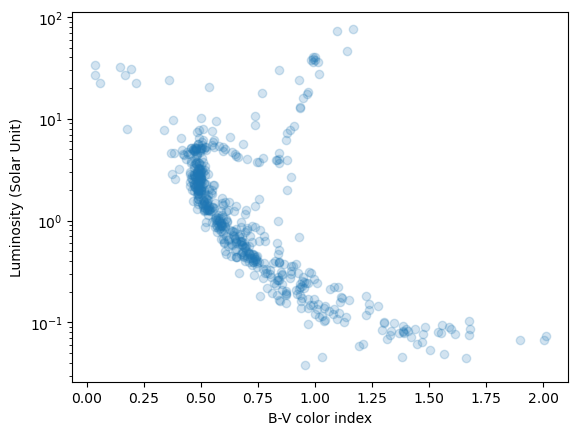

In [133]:
plt.scatter(gaia_cluster['B_magnitude'] - gaia_cluster['V_magnitude'], gaia_cluster['Luminosity'], alpha = 0.20)
plt.yscale('log')
plt.xlabel('B-V color index')
plt.ylabel('Luminosity (Solar Unit)')
plt.savefig("B_V.png", dpi = 300)

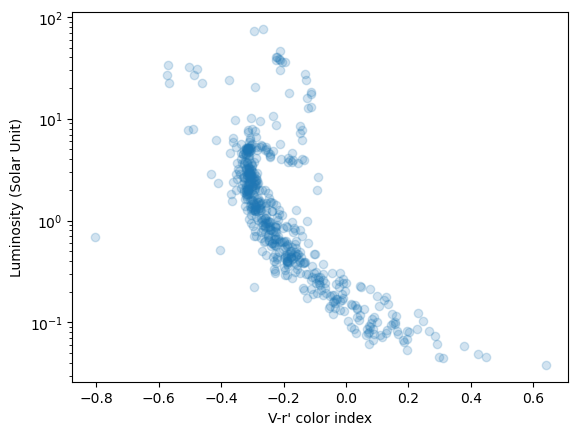

In [134]:
plt.scatter(gaia_cluster['V_magnitude'] - gaia_cluster['r_magnitude'], gaia_cluster['Luminosity'], alpha = 0.20)
plt.yscale('log')
plt.xlabel('V-r\' color index')
plt.ylabel('Luminosity (Solar Unit)')
plt.savefig("V_r.png", dpi = 300)

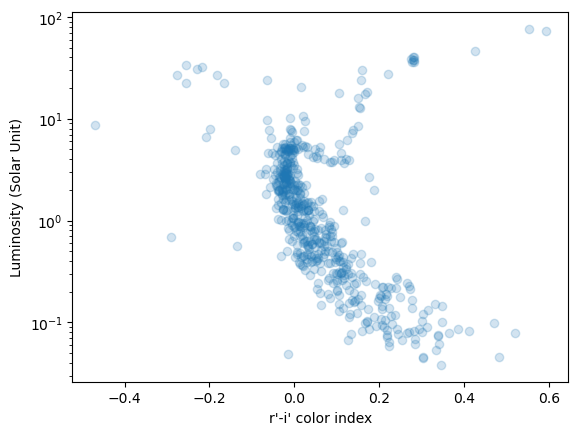

In [135]:
plt.scatter(gaia_cluster['r_magnitude'] - gaia_cluster['i_magnitude'], gaia_cluster['Luminosity'], alpha = 0.20)
plt.yscale('log')
plt.xlabel('r\'-i\' color index')
plt.ylabel('Luminosity (Solar Unit)')
plt.savefig("r_i.png", dpi = 300)

# Multiple Reference Star

In [ ]:
# find the intensity of the reference star
name = ['Gaia DR3 604918106095629952','Gaia DR3 604920687371751936','Gaia DR3 604921134048349824']
B_m_0 = [15.45,15.22,14.54]
V_m_0 = [14.718,14.746,13.978]
r_m_0 = [14.527,15.957,13.805]
i_m_0 = [14.347,14.758,15.241]
for i in range(len(name)):
  ref_star = gaia_cluster[gaia_cluster['DESIGNATION'] == name[i]]
  #extract intensity of ref star
  B_f_0 = ref_star['B_intensity'][0]
  V_f_0 = ref_star['V_intensity'][0]
  r_f_0 = ref_star['r_intensity'][0]
  i_f_0 = ref_star['i_intensity'][0]

In [132]:
B_magnitude = np.zeros(len(gaia_cluster))
V_magnitude = np.zeros(len(gaia_cluster))
r_magnitude = np.zeros(len(gaia_cluster))
i_magnitude = np.zeros(len(gaia_cluster))
for j in range(len(name)):

  for i in range(len(gaia_cluster)):
      B_magnitude[i] = B_magnitude[i] + B_m_0[j] - 2.5 * np.log10(gaia_cluster['B_intensity'][i] / B_f_0)

  for i in range(len(gaia_cluster)):
      V_magnitude[i] = V_magnitude[i] + V_m_0[j] - 2.5 * np.log10(gaia_cluster['V_intensity'][i] / V_f_0)


  for i in range(len(gaia_cluster)):
      r_magnitude[i] = r_magnitude[i] + r_m_0[j] - 2.5 * np.log10(gaia_cluster['r_intensity'][i] / r_f_0)

  for i in range(len(gaia_cluster)):
      i_magnitude[i] = i_magnitude[i] + i_m_0[j] - 2.5 * np.log10(gaia_cluster['i_intensity'][i] / i_f_0)

gaia_cluster['B_magnitude'] = B_magnitude / len(name)
gaia_cluster['V_magnitude'] = V_magnitude / len(name)
gaia_cluster['r_magnitude'] = r_magnitude / len(name)
gaia_cluster['i_magnitude'] = i_magnitude / len(name)

In [138]:
x = []
y = []
r = []
a = gaia_cluster[gaia_cluster['DESIGNATION'] == 'Gaia DR3 604918106095629952']
b = gaia_cluster[gaia_cluster['DESIGNATION'] == 'Gaia DR3 604920687371751936']
c = gaia_cluster[gaia_cluster['DESIGNATION'] == 'Gaia DR3 604921134048349824']
x = [a['Bx'], b['Bx'], c['Bx']]
y = [a['By'], b['By'], c['By']]
r = [a['Br'], b['Br'], c['Br']]

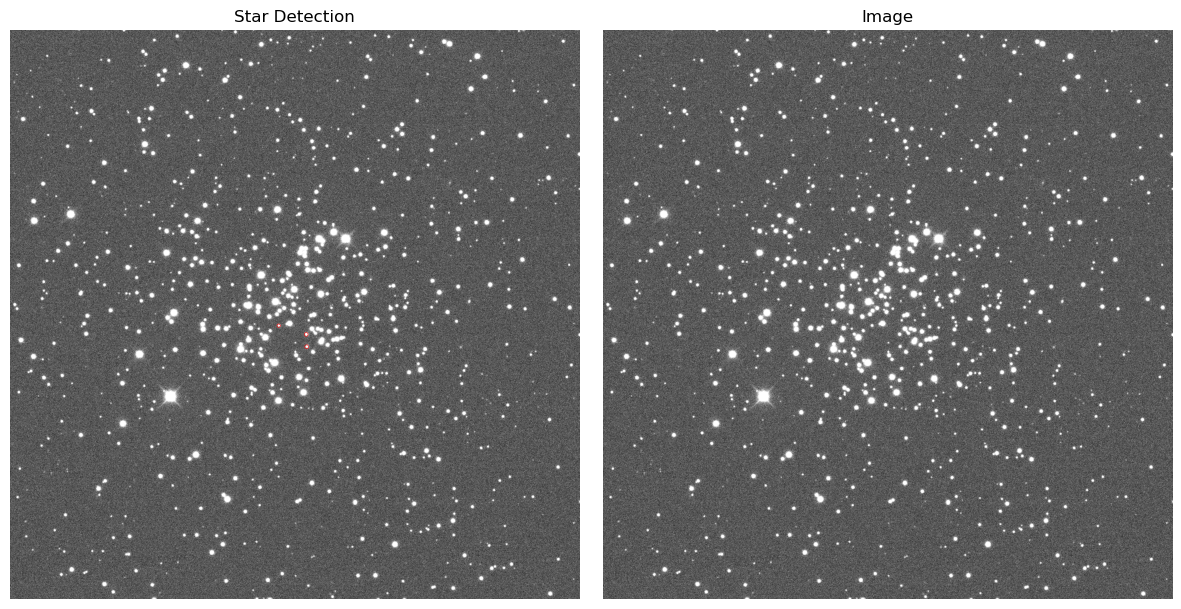

In [143]:
visual_detect(sci_image= B_sci, x = x, y = y, size = r, save='ref_star')

In [137]:
gaia_cluster.info()

<Table length=553>
      name       dtype    unit                              description                                class    
--------------- ------- -------- ------------------------------------------------------------------ ------------
    DESIGNATION  object                 Unique source designation (unique across all Data Releases) MaskedColumn
      SOURCE_ID   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn
             pm float32 mas / yr                                                Total proper motion MaskedColumn
       parallax float64      mas                                                           Parallax MaskedColumn
   detect_count   int64                                                                                   Column
             Bx   int64                                                                                   Column
             By   int64                                                      